In [19]:
import numpy as np
import matplotlib.pyplot as plt
from dask.array import shape
from scipy.special import legendre
from scipy.integrate import quadrature
import sympy as sp

## (a)&(b)&(c)

In [20]:
def f(x):
    return 1/(1+25*x**2)

In [21]:
def interpo_eq(N,a,b):#牛顿差商计算多项式系数，等距点
    num_intervals=N-1
    h=(b-a)/num_intervals
    x=np.zeros(N)
    fx=np.zeros(N)
    F=np.zeros((N,N))
    for i in range(N):
        x[i]=a+i*h
        fx[i]=f(x[i])
        F[i,0]=fx[i]
    for i in range(1,num_intervals+1):
        for j in range(1,i+1):
            num=F[i,j-1]-F[i-1,j-1]
            den=x[i]-x[i-j]
            F[i,j]=num/den
    return F,x

In [22]:
def interpo_any(x):#牛顿差商计算多项式系数，任意点
    N=x.shape[0]
    num_intervals=N-1
    fx=np.zeros(N)
    F=np.zeros((N,N))
    for i in range(N):
        fx[i]=f(x[i])
        F[i,0]=fx[i]
    for i in range(1,num_intervals+1):
        for j in range(1,i+1):
            num=F[i,j-1]-F[i-1,j-1]
            den=x[i]-x[i-j]
            F[i,j]=num/den
    return F

In [23]:
def inter_poly(F,z,x):#根据牛顿差商多项式系数计算多项式值
    poly=F[0,0]
    for i in range(1,F.shape[0]):
        product=1
        for j in range(0,i):
            product*=(x-z[j])
        poly+=F[i,i]*product
    return poly

In [24]:
def legendre_roots(N):#计算 N 阶 Legendre 多项式的根。
    # 获取 N 阶 Legendre 多项式的系数
    P = legendre(N)
    # 使用 numpy 的多项式求根方法
    roots = P.roots
    return roots

## （d-g）

In [25]:
def legendre_least_squares(f_str, N):
    #使用 N-1 次 Legendre 多项式对函数 f(x) 在 [-1, 1] 上进行最小二乘逼近。参数：f_str (str): 目标函数的字符串形式。N: 使用的 Legendre 多项式的最高阶为 N-1。
    # 返回：sympy.Expr: 最小二乘逼近的多项式。
    #使用符号运算求积分的解析数值
    # 定义符号变量
    x = sp.symbols('x')
    # 解析目标函数
    f = sp.sympify(f_str)
    # 计算 N-1 次的 Legendre 多项式系数和表达式
    P = [sp.legendre(i, x) for i in range(N)]
    coefficients = []
    for i in range(N):
        # 计算系数 c_i = <f, P_i> / <P_i, P_i>
        numerator = sp.integrate(f * P[i], (x, -1, 1))
        denominator = sp.integrate(P[i]**2, (x, -1, 1))
        coefficients.append(numerator / denominator)
    # 构造最小二乘多项式
    approx_poly = sum(coefficients[i] * P[i] for i in range(N))
    return sp.simplify(approx_poly)

funx = "1 / (1 + 25 * x**2)"


In [26]:
# 最小二乘逼近的系数计算(高斯数值积分法)
def least_squares_coefficients(N, f):
    coefficients = []
    x, w = np.polynomial.legendre.leggauss(N)# 高斯-勒让德积分根和系数
    for n in range(N):
        Pn = legendre(n)
        def integrand(x):
            return f(x) * Pn(x)
        integral = np.sum(w * integrand(x))#高斯-勒让德积分
        coefficients.append(integral * (2 * n + 1) / 2) #乘以权重归一化
    return coefficients
# 构造逼近函数
def approximate_function(x, coefficients):
    approx = 0
    for n, c in enumerate(coefficients):
        Pn = legendre(n)
        approx += c * Pn(x)
    return approx

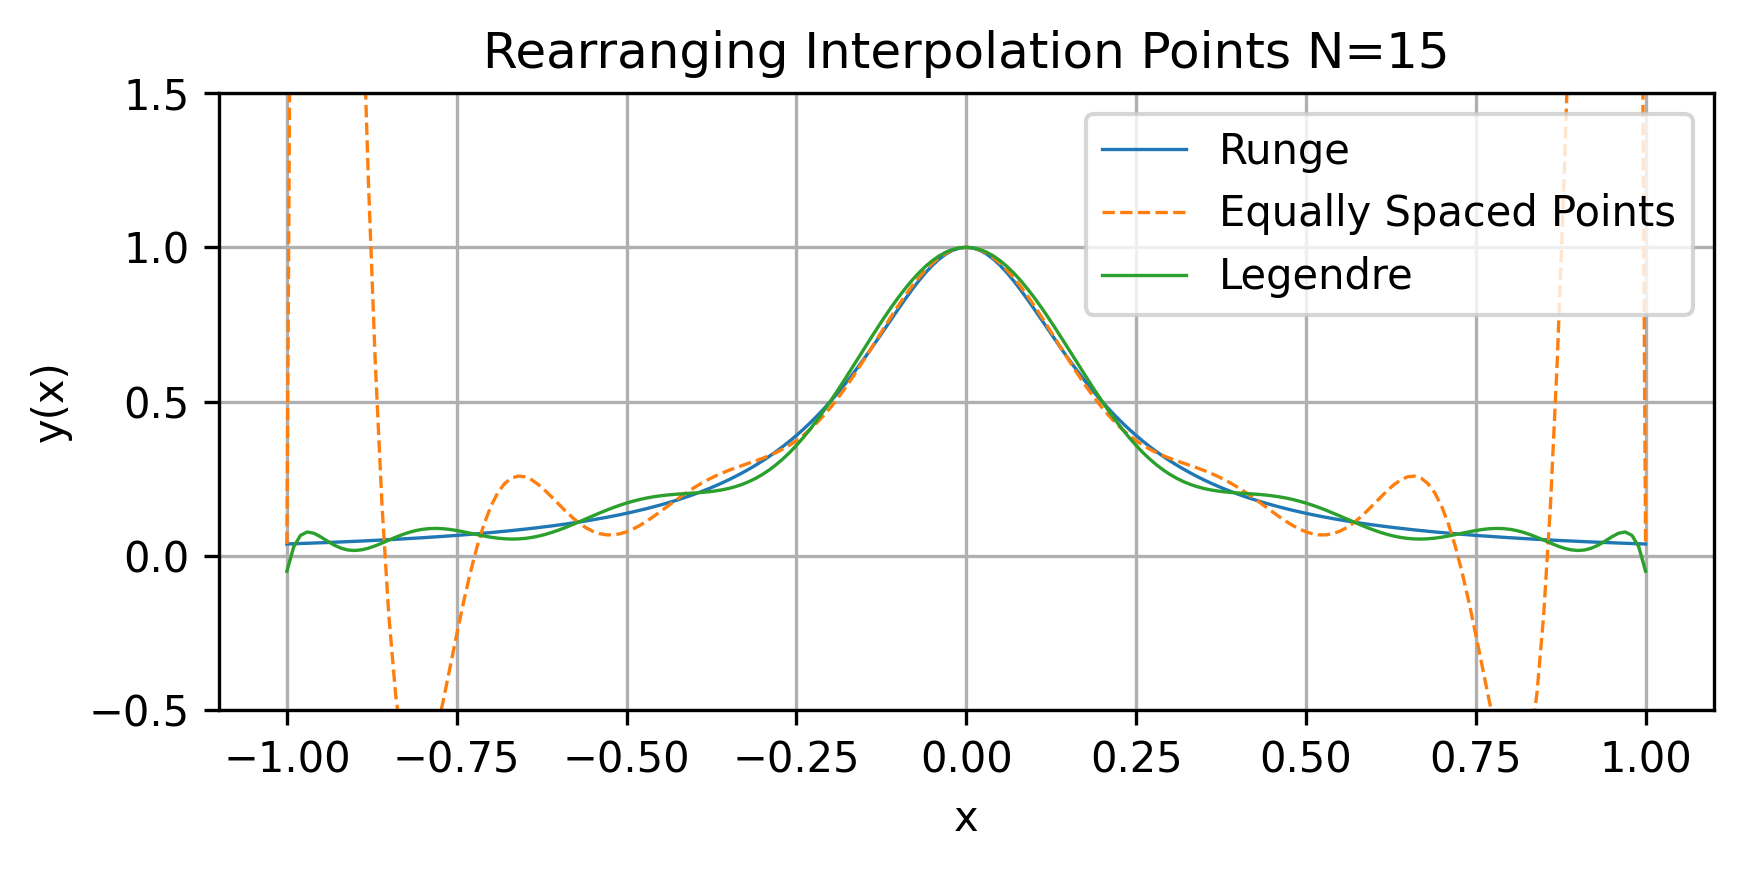

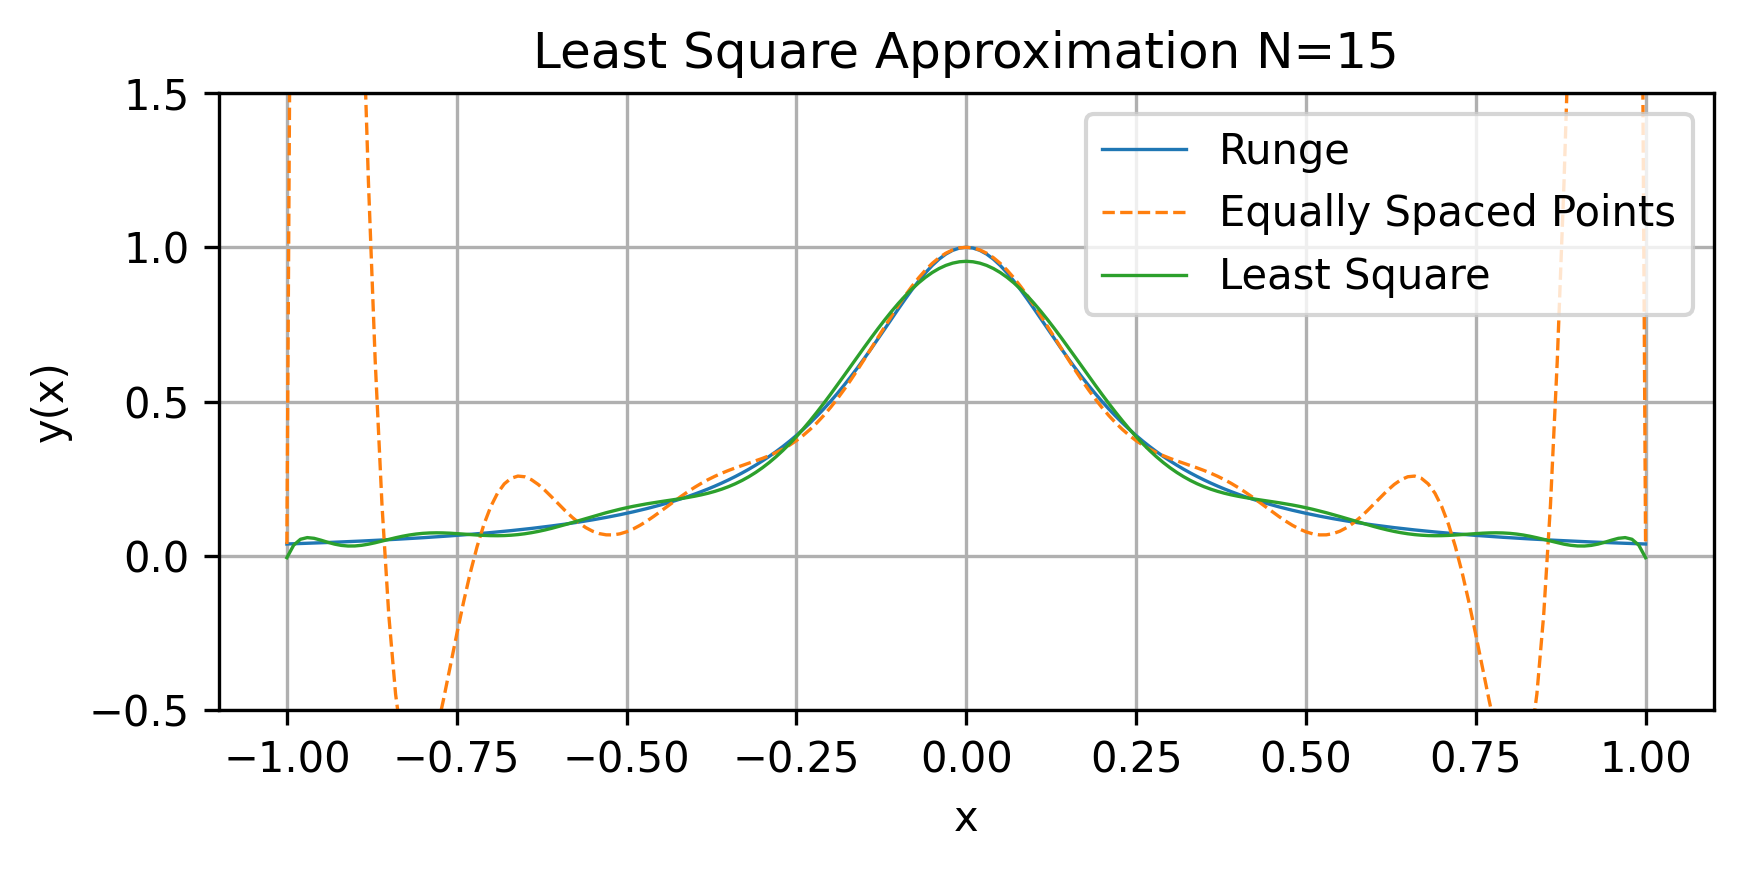

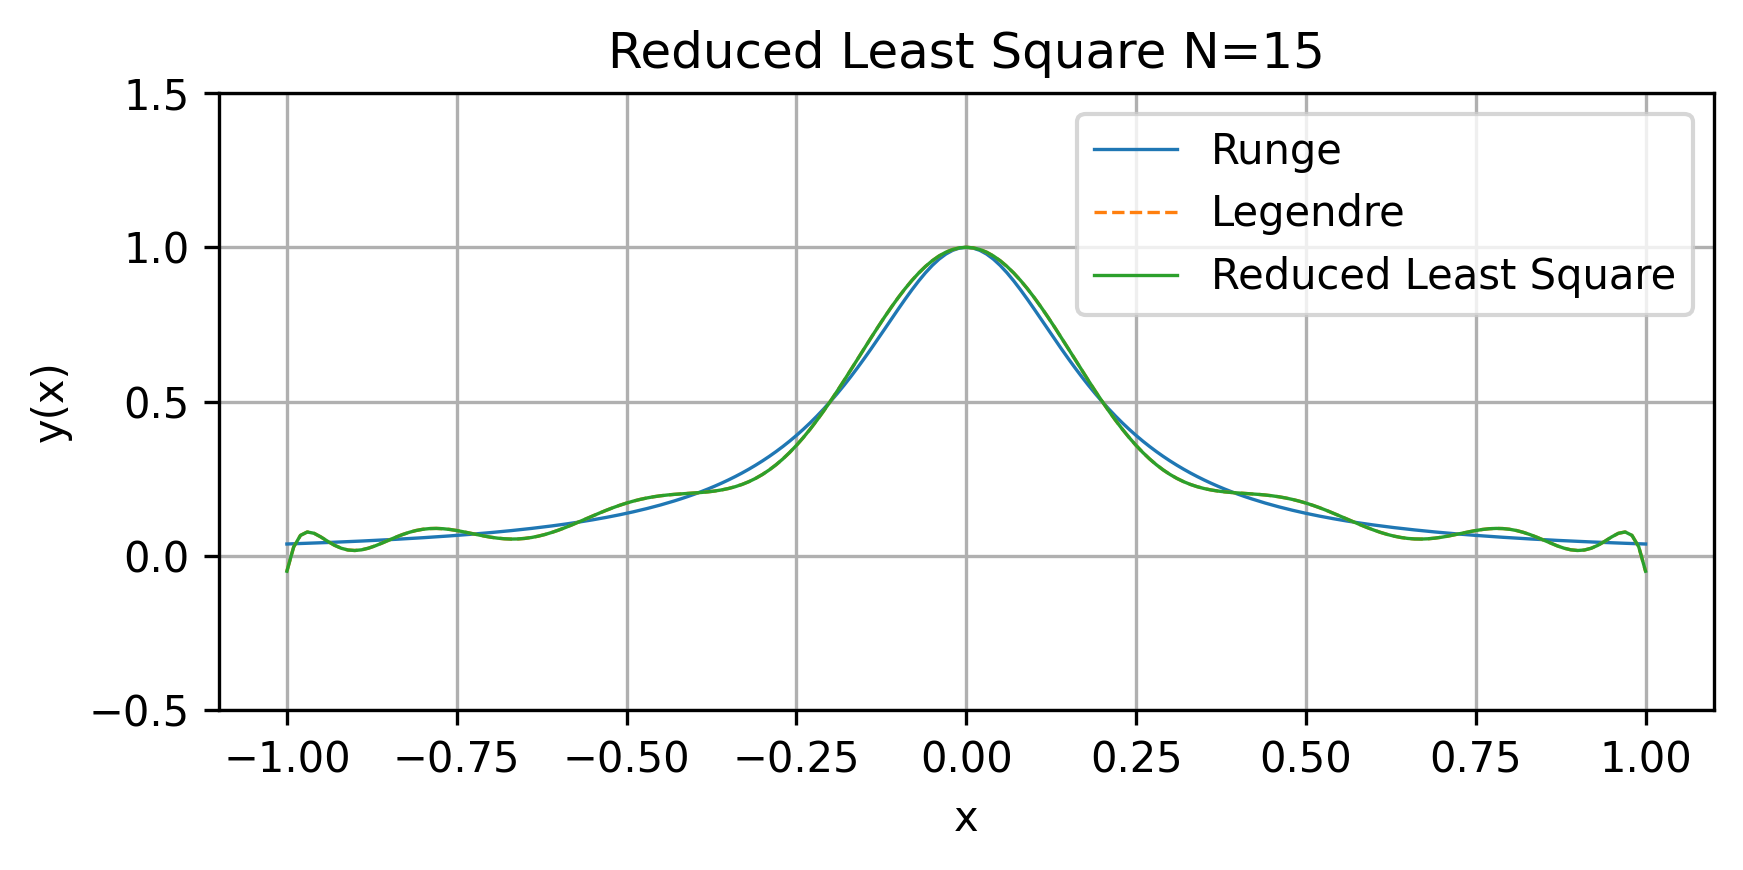

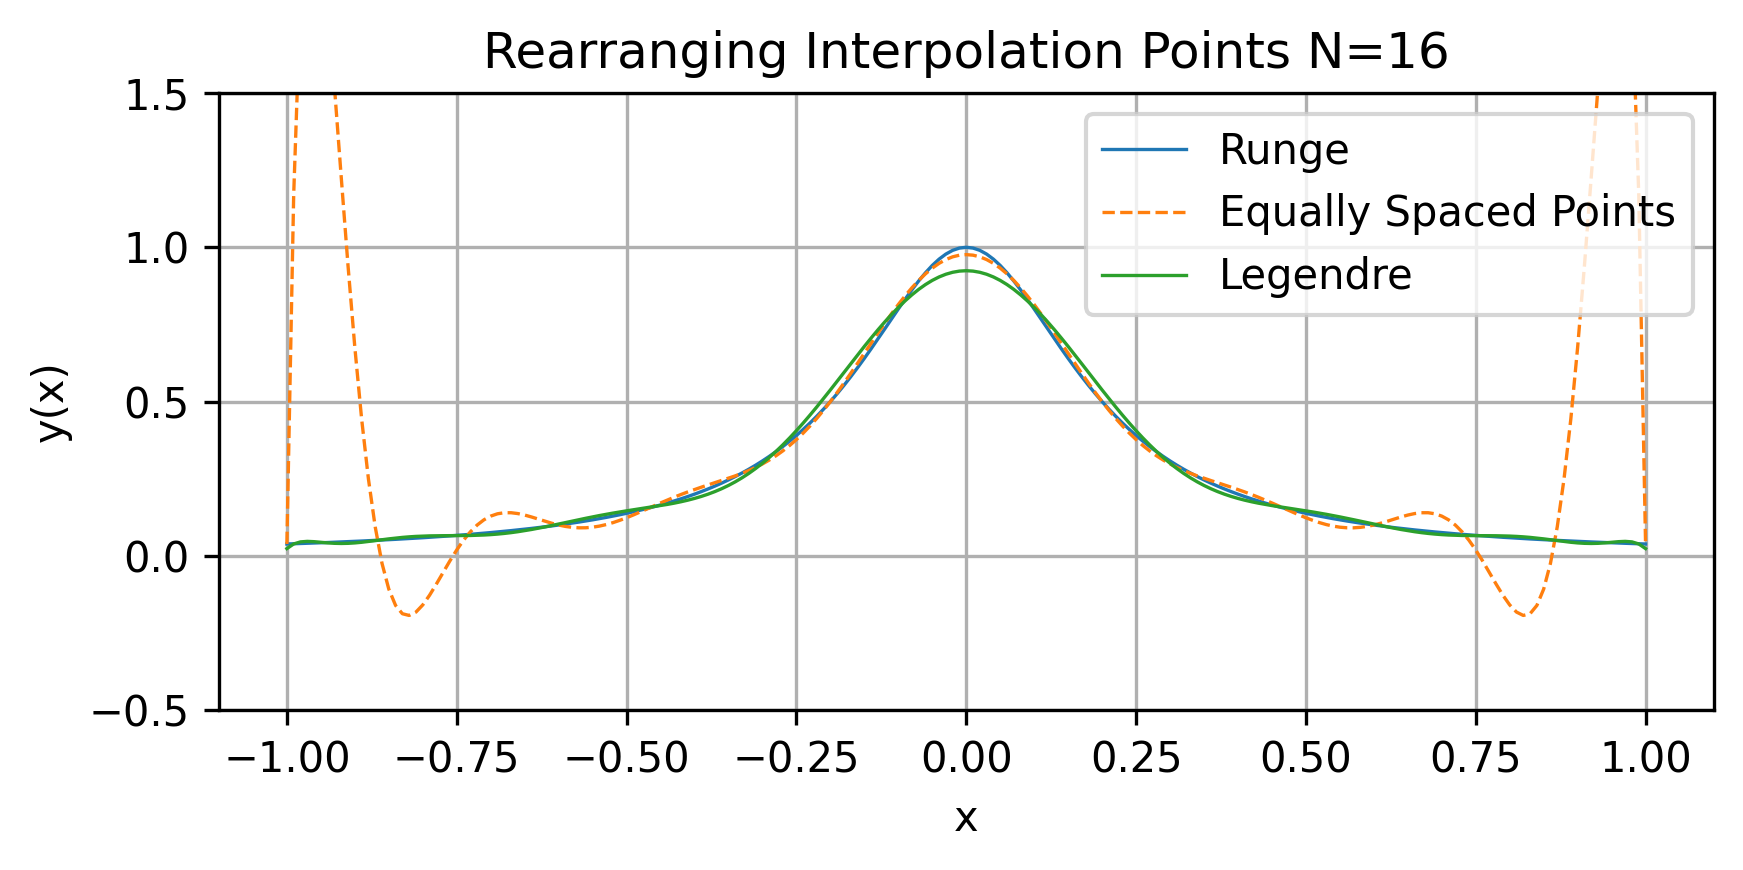

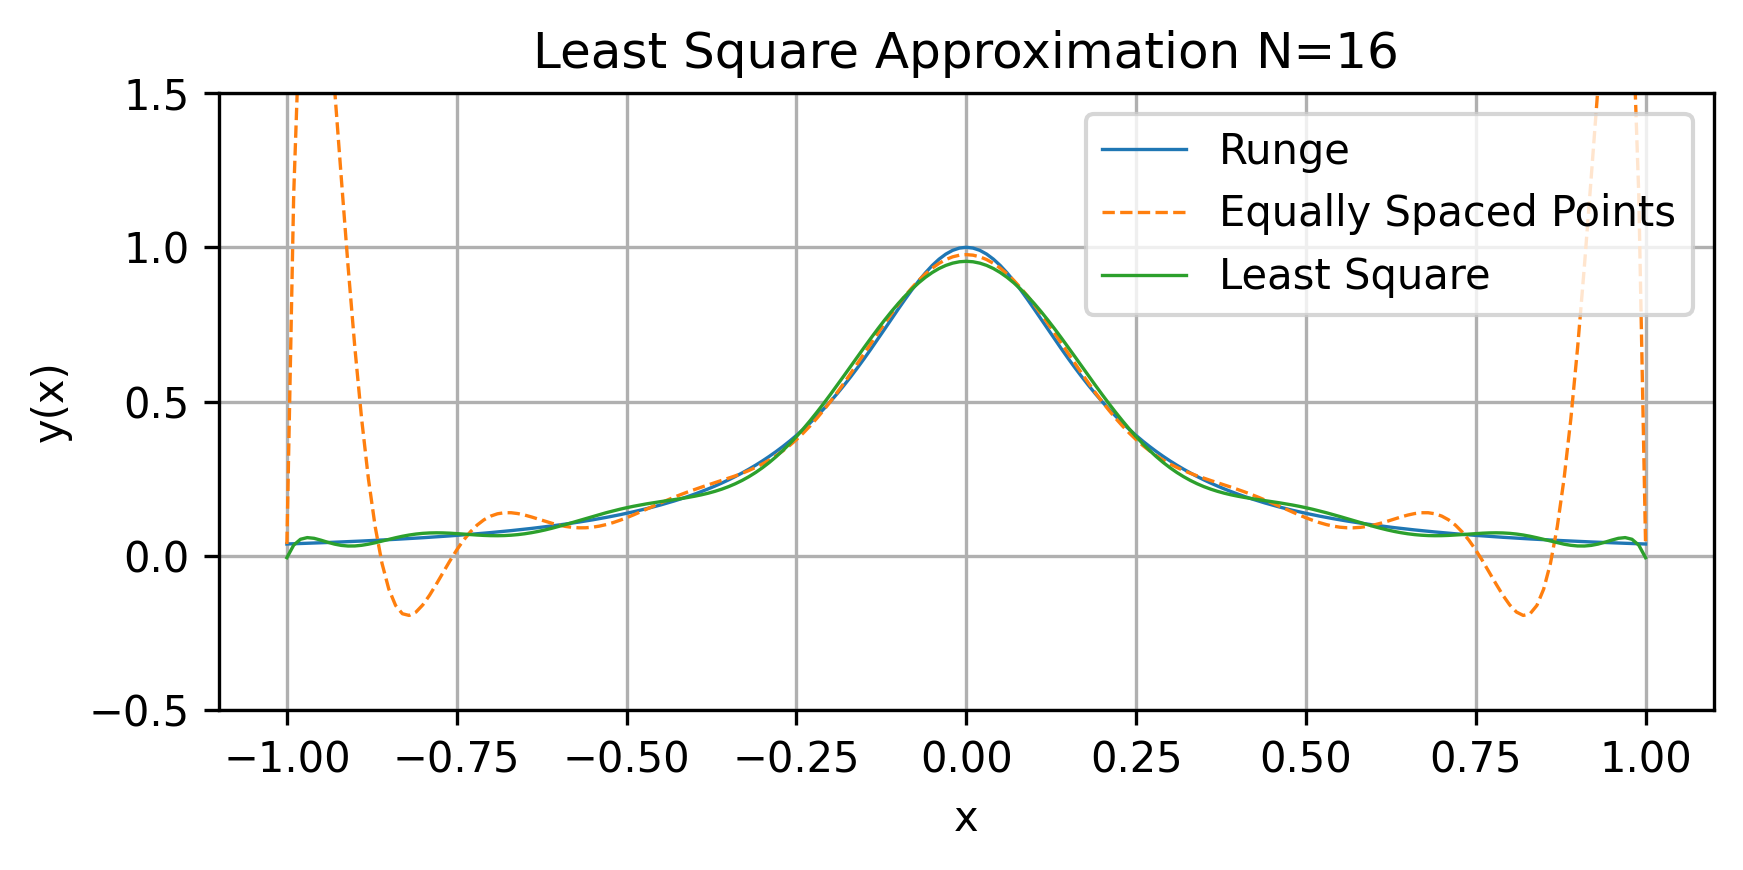

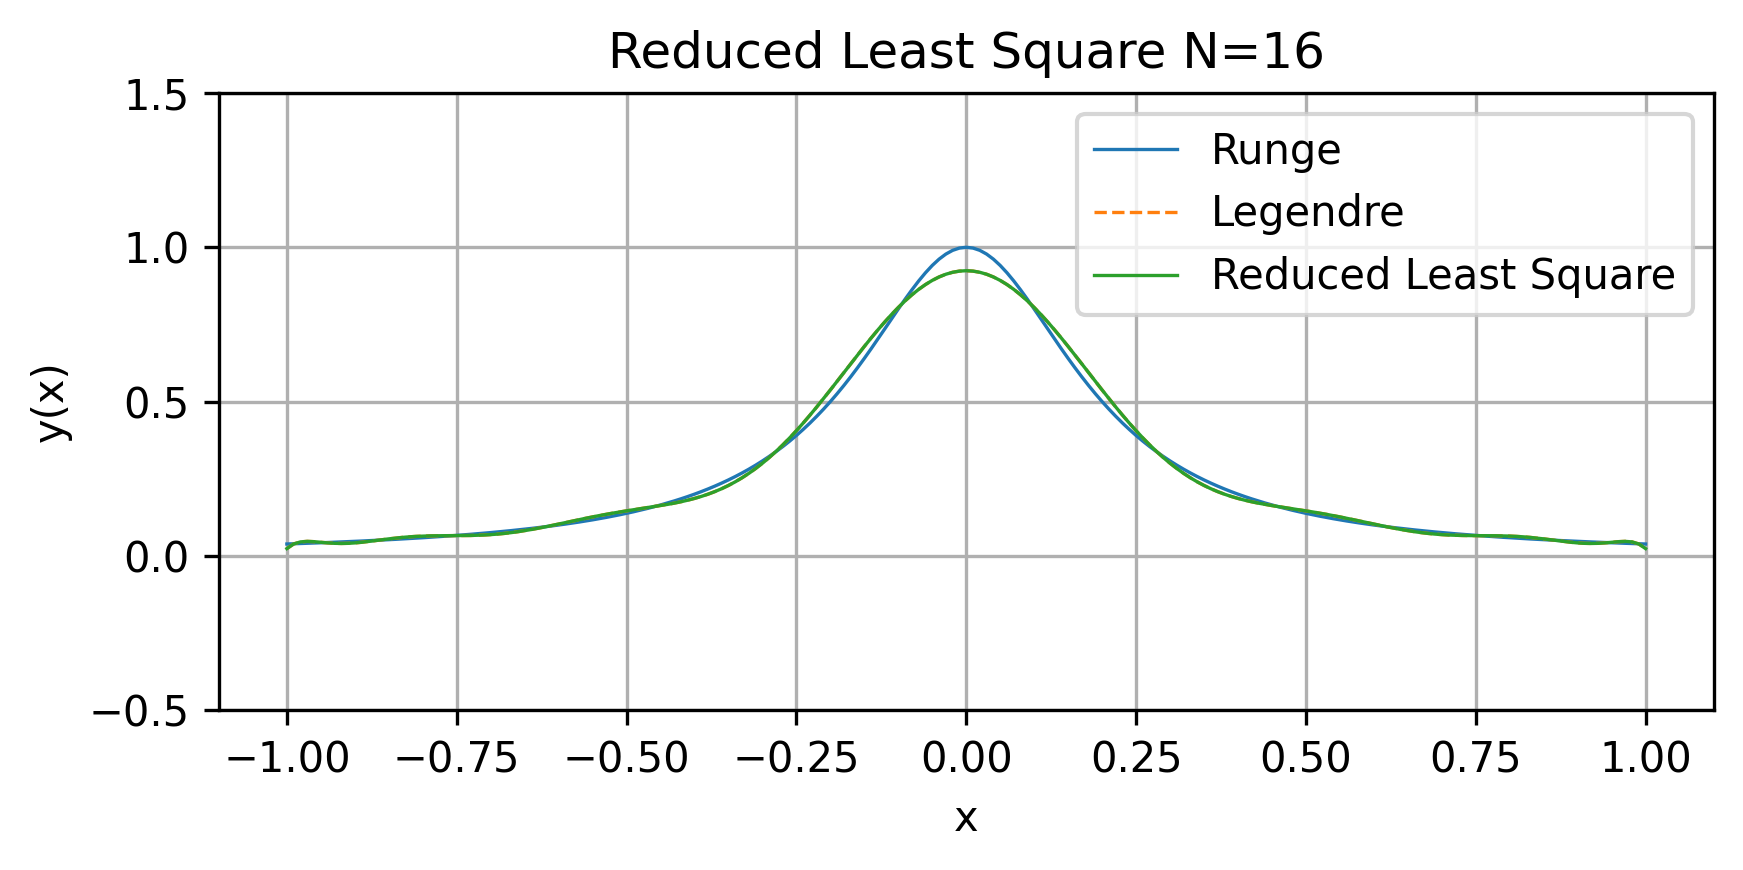

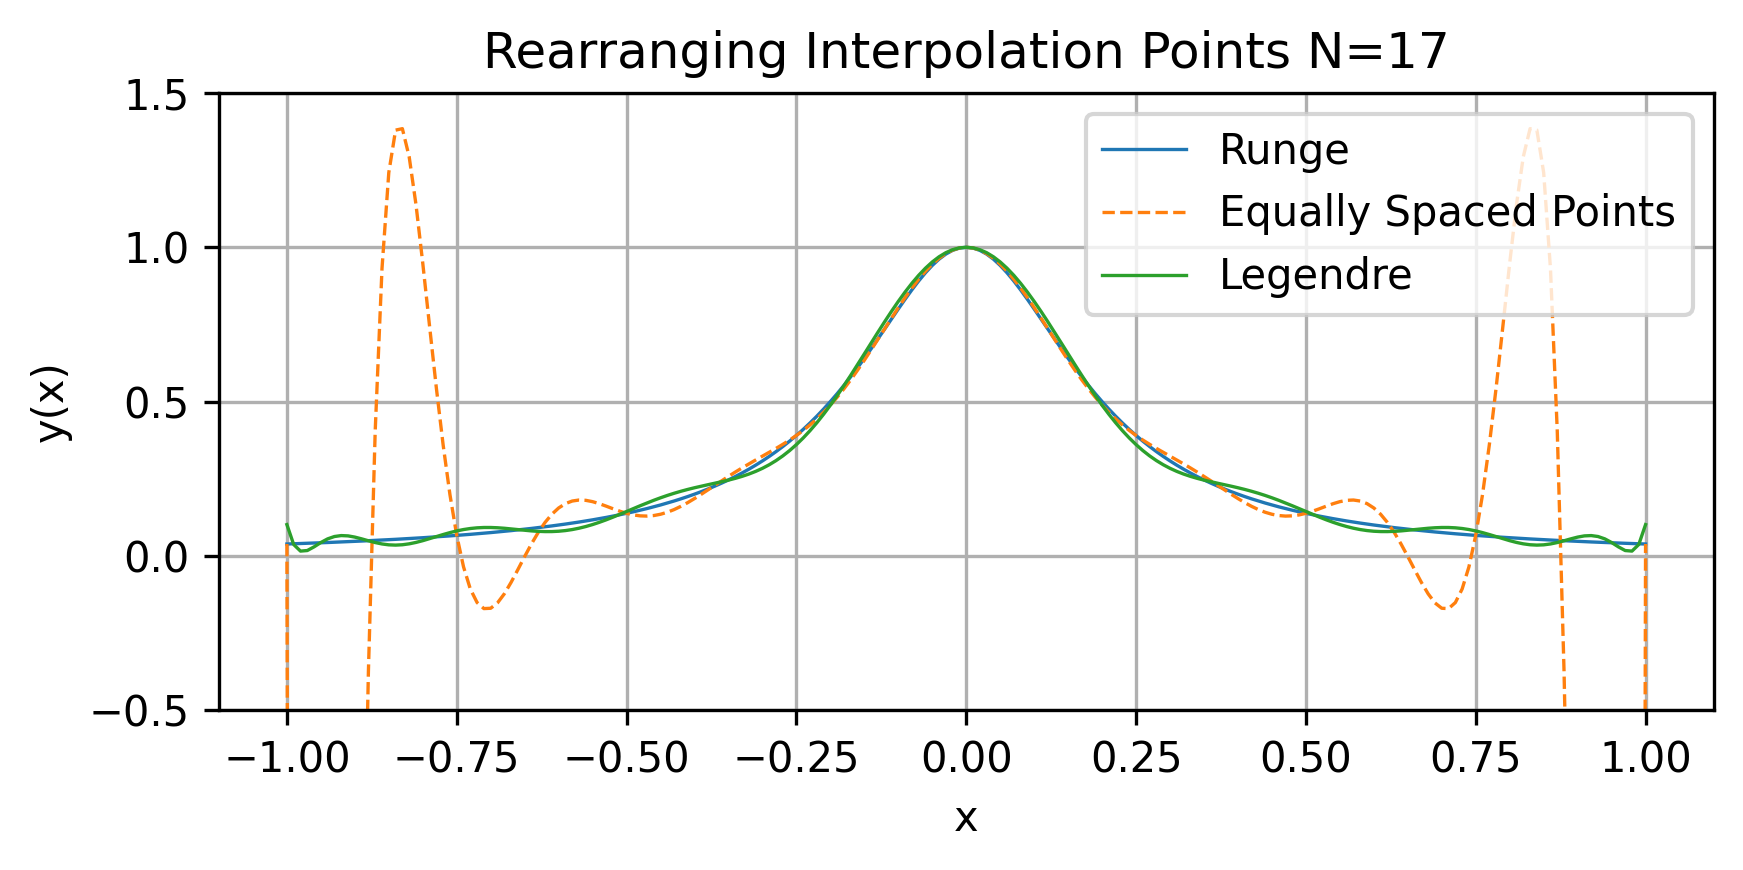

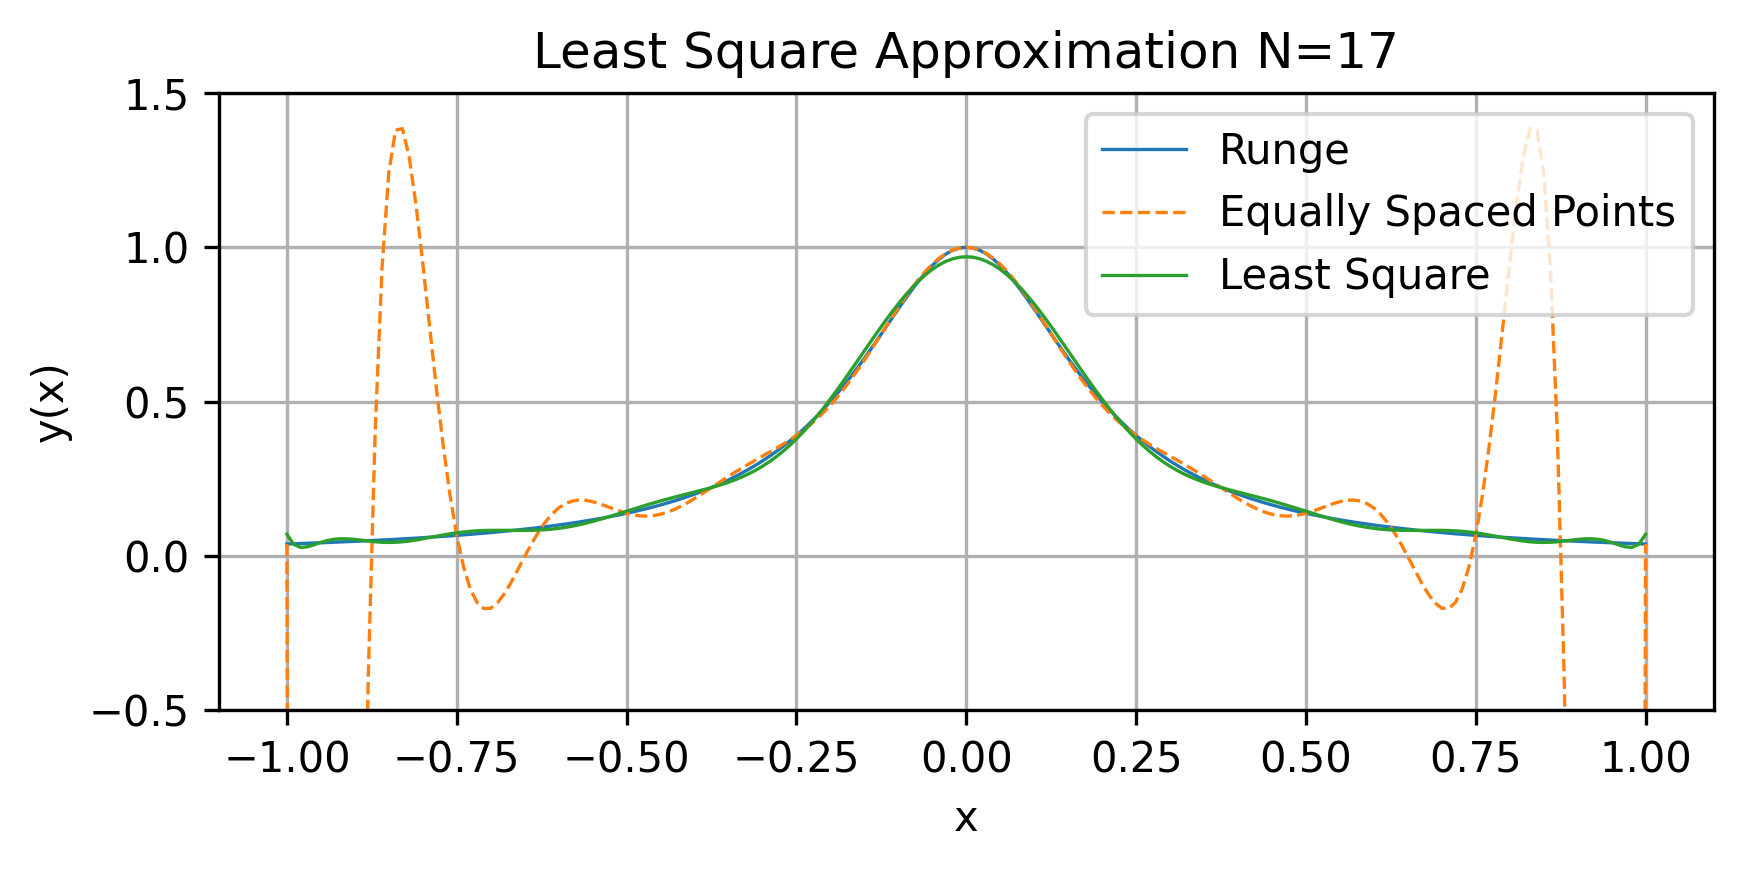

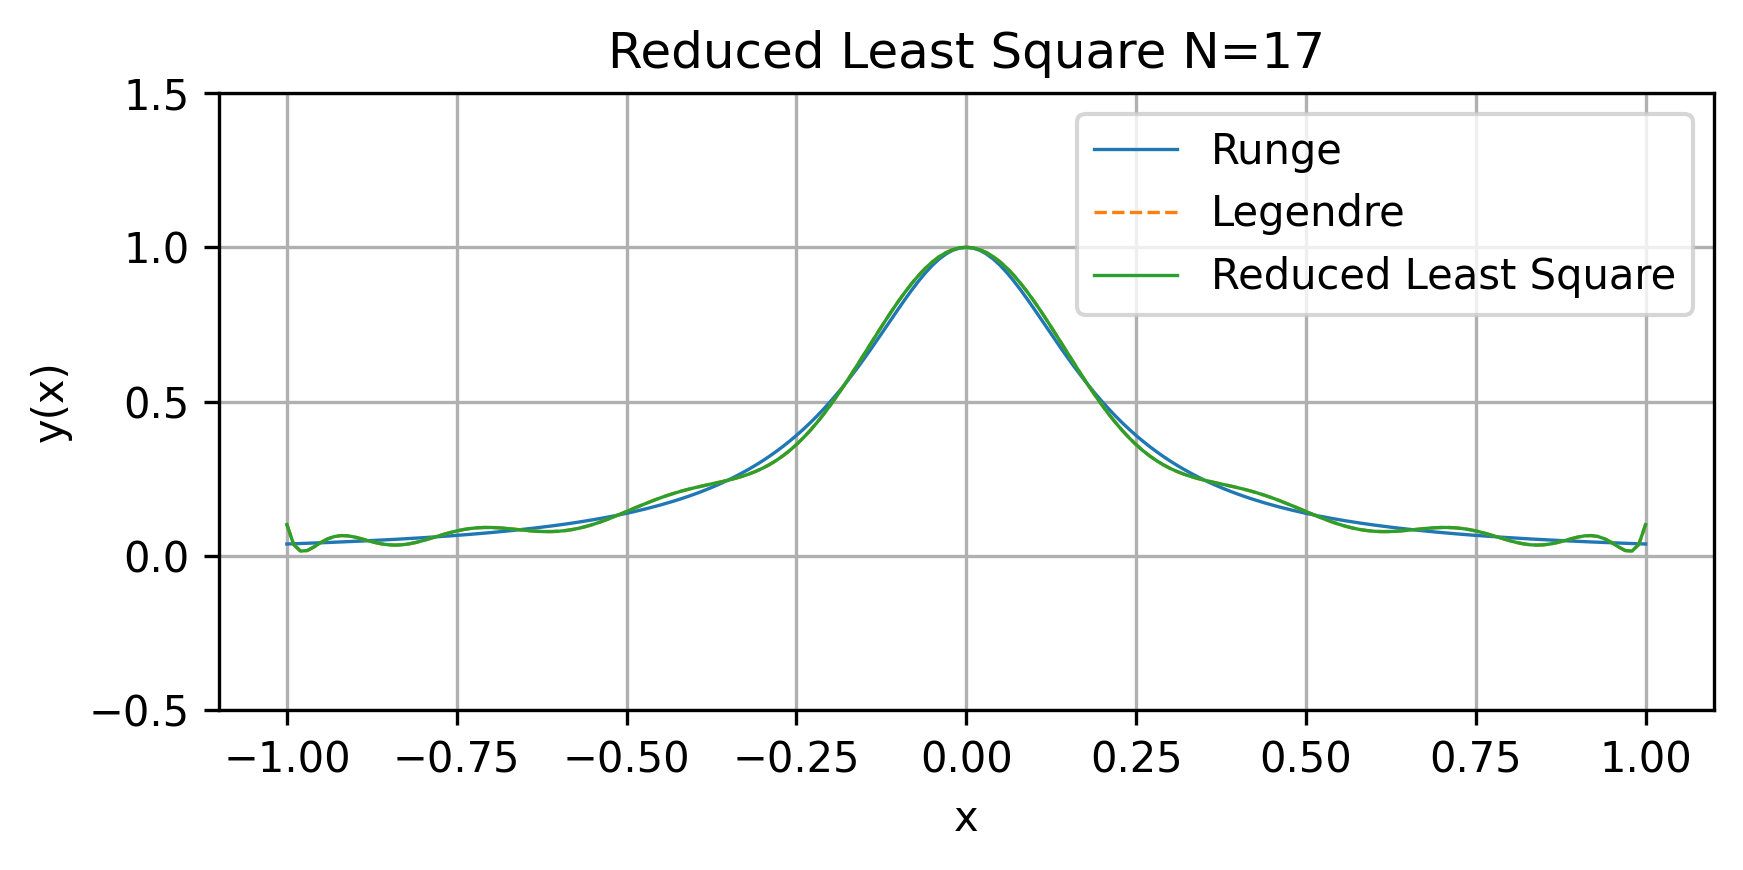

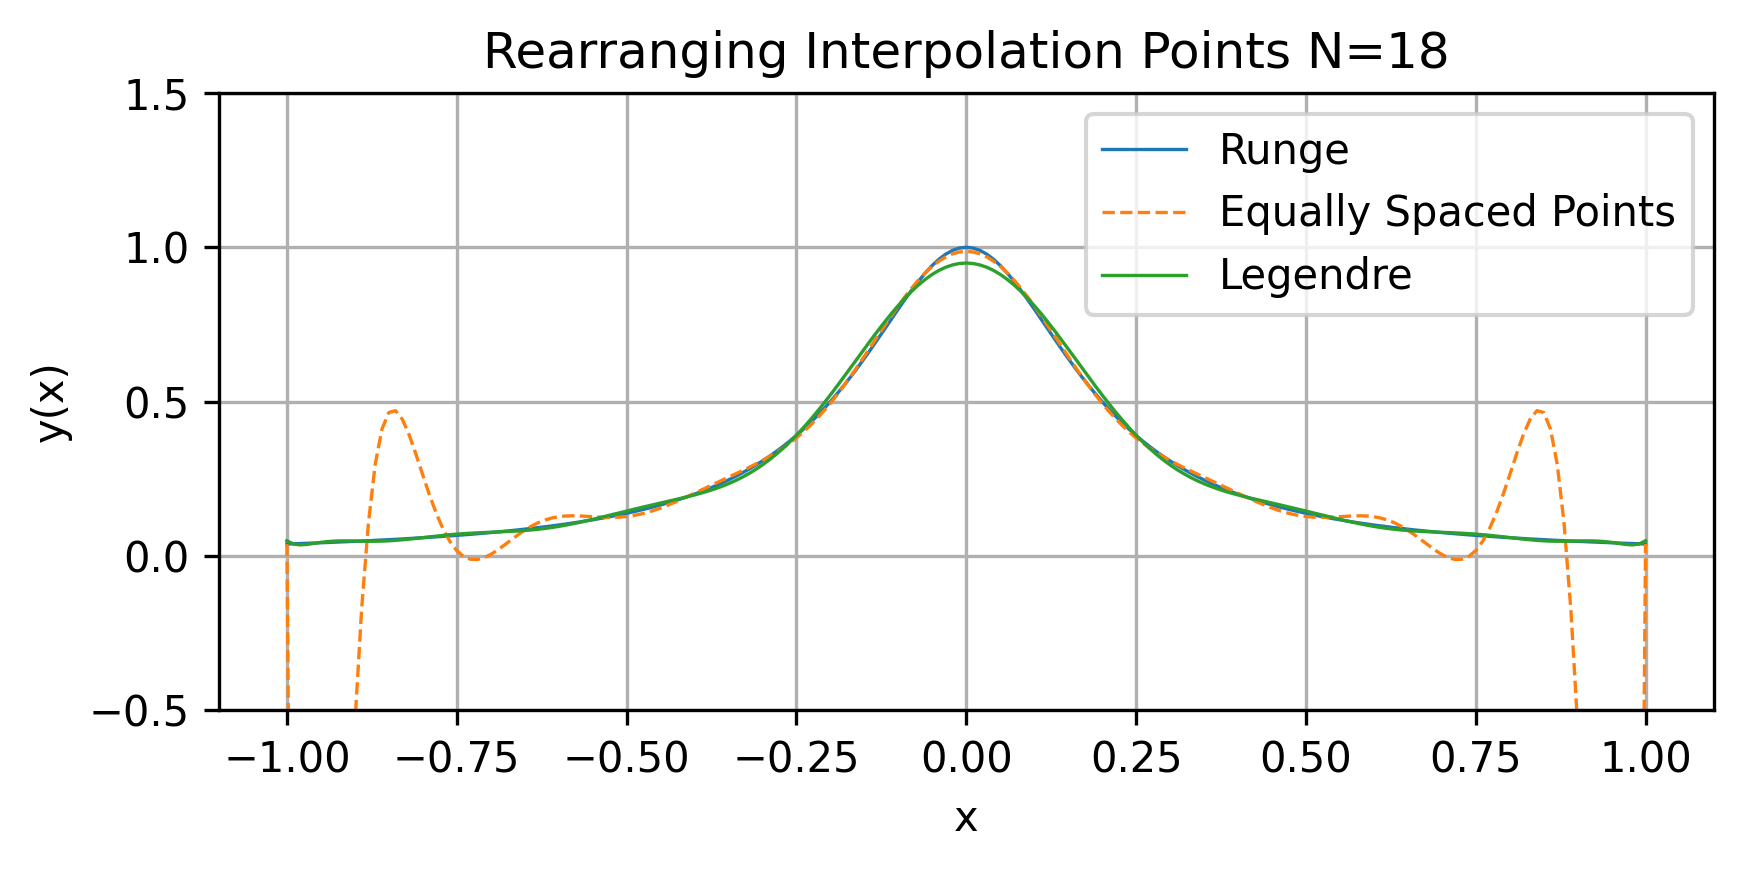

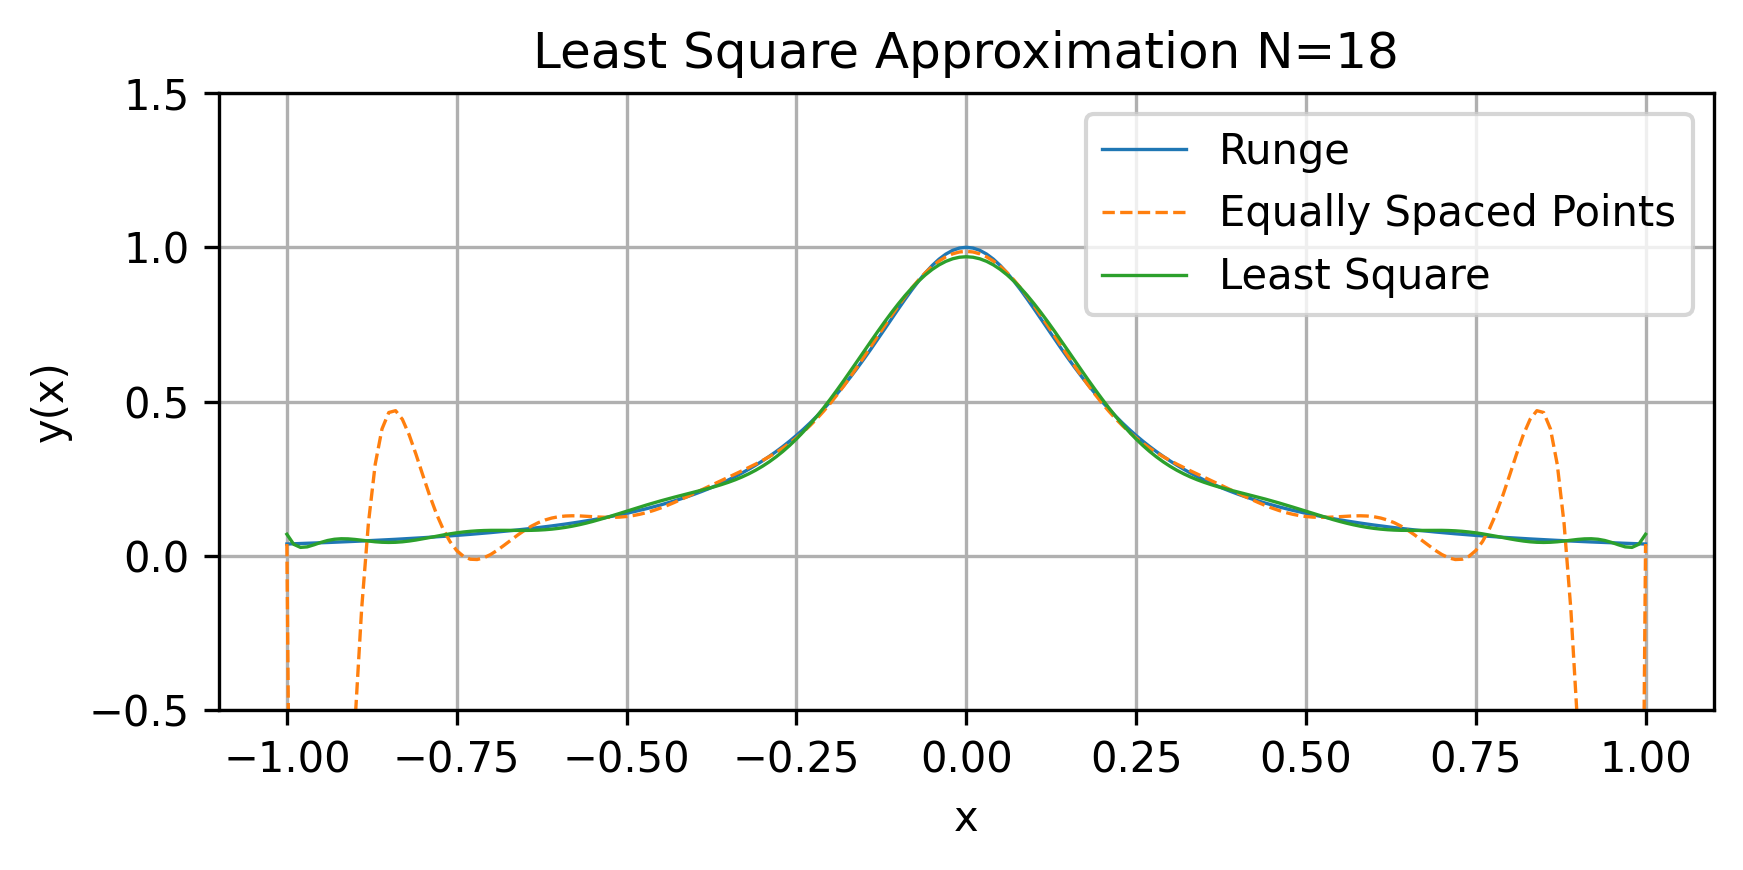

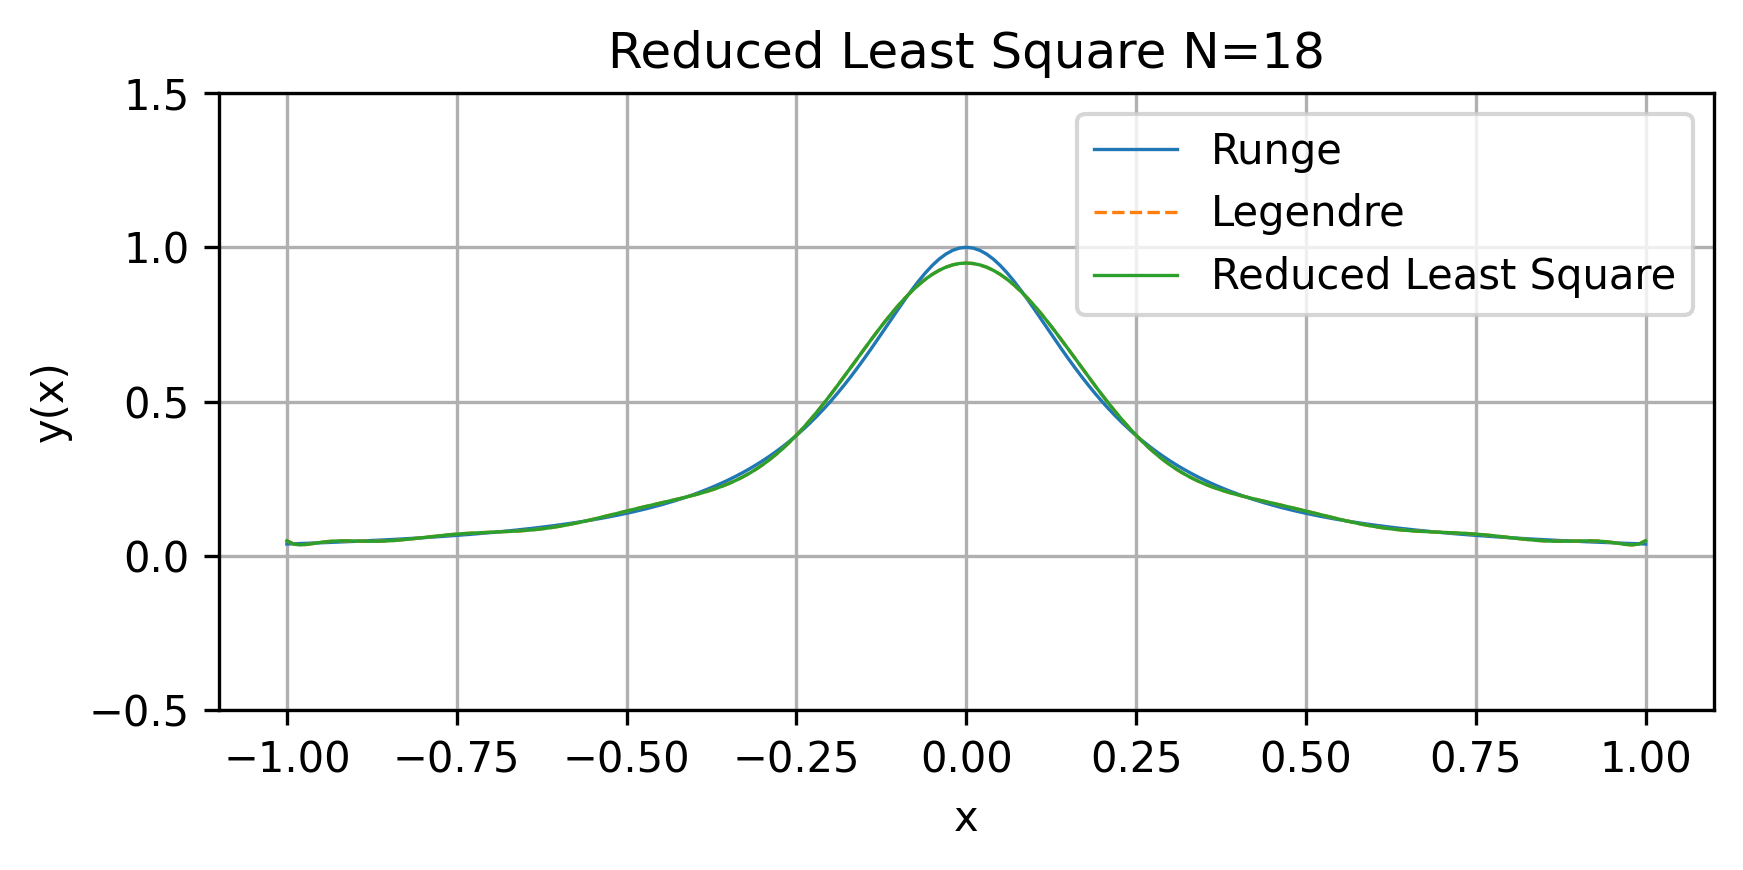

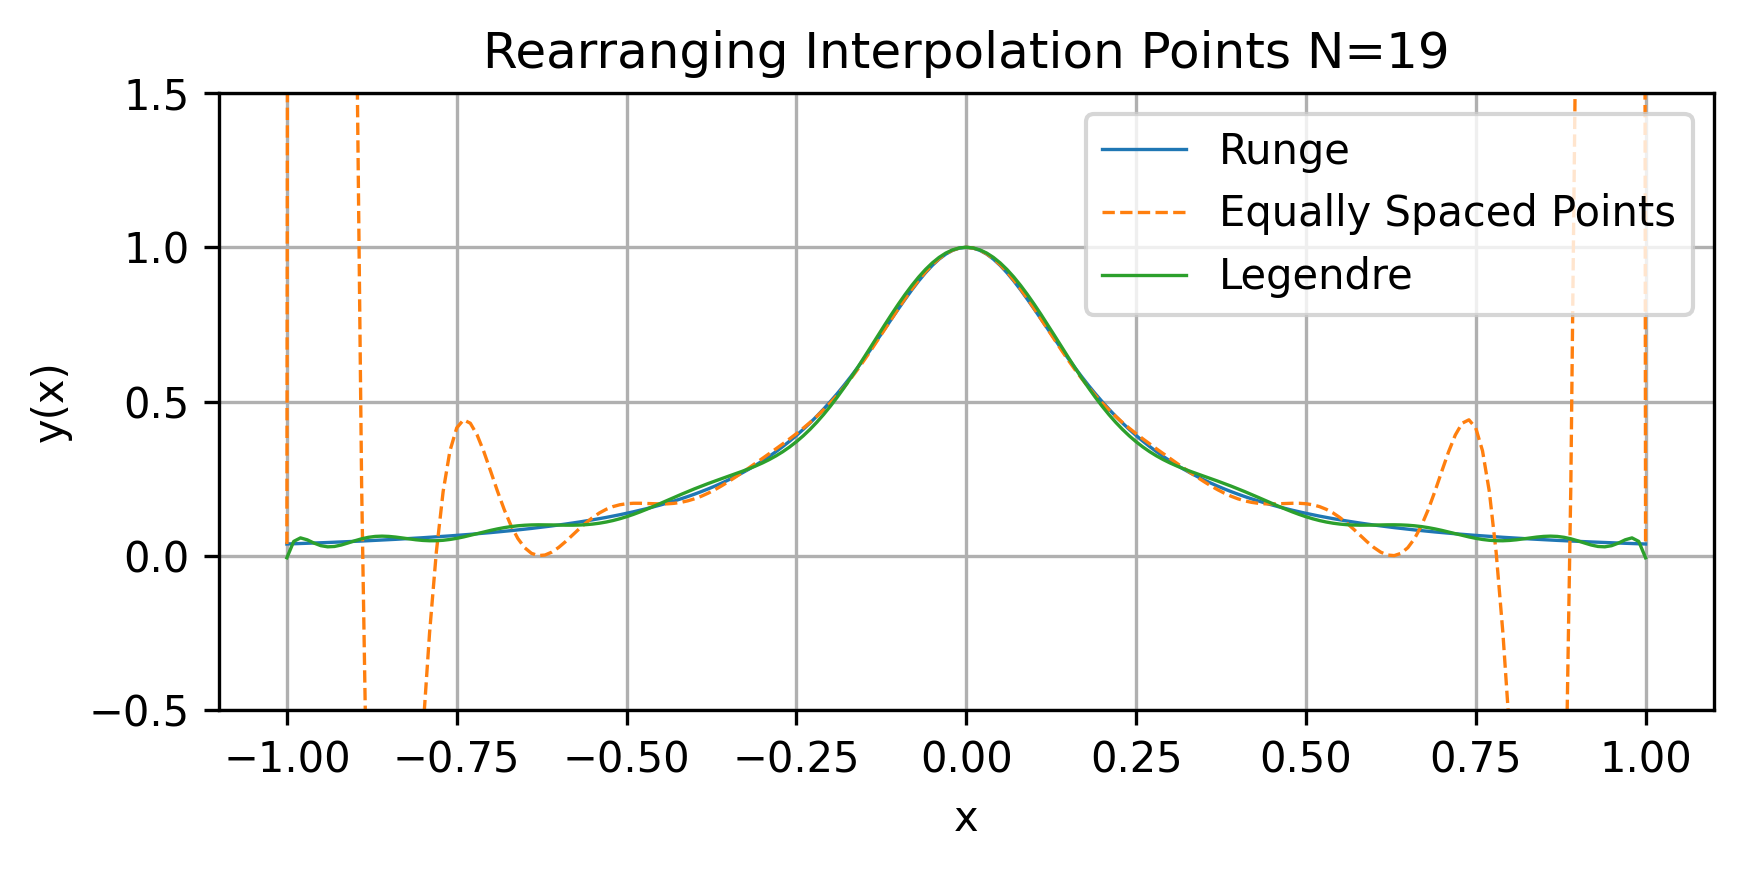

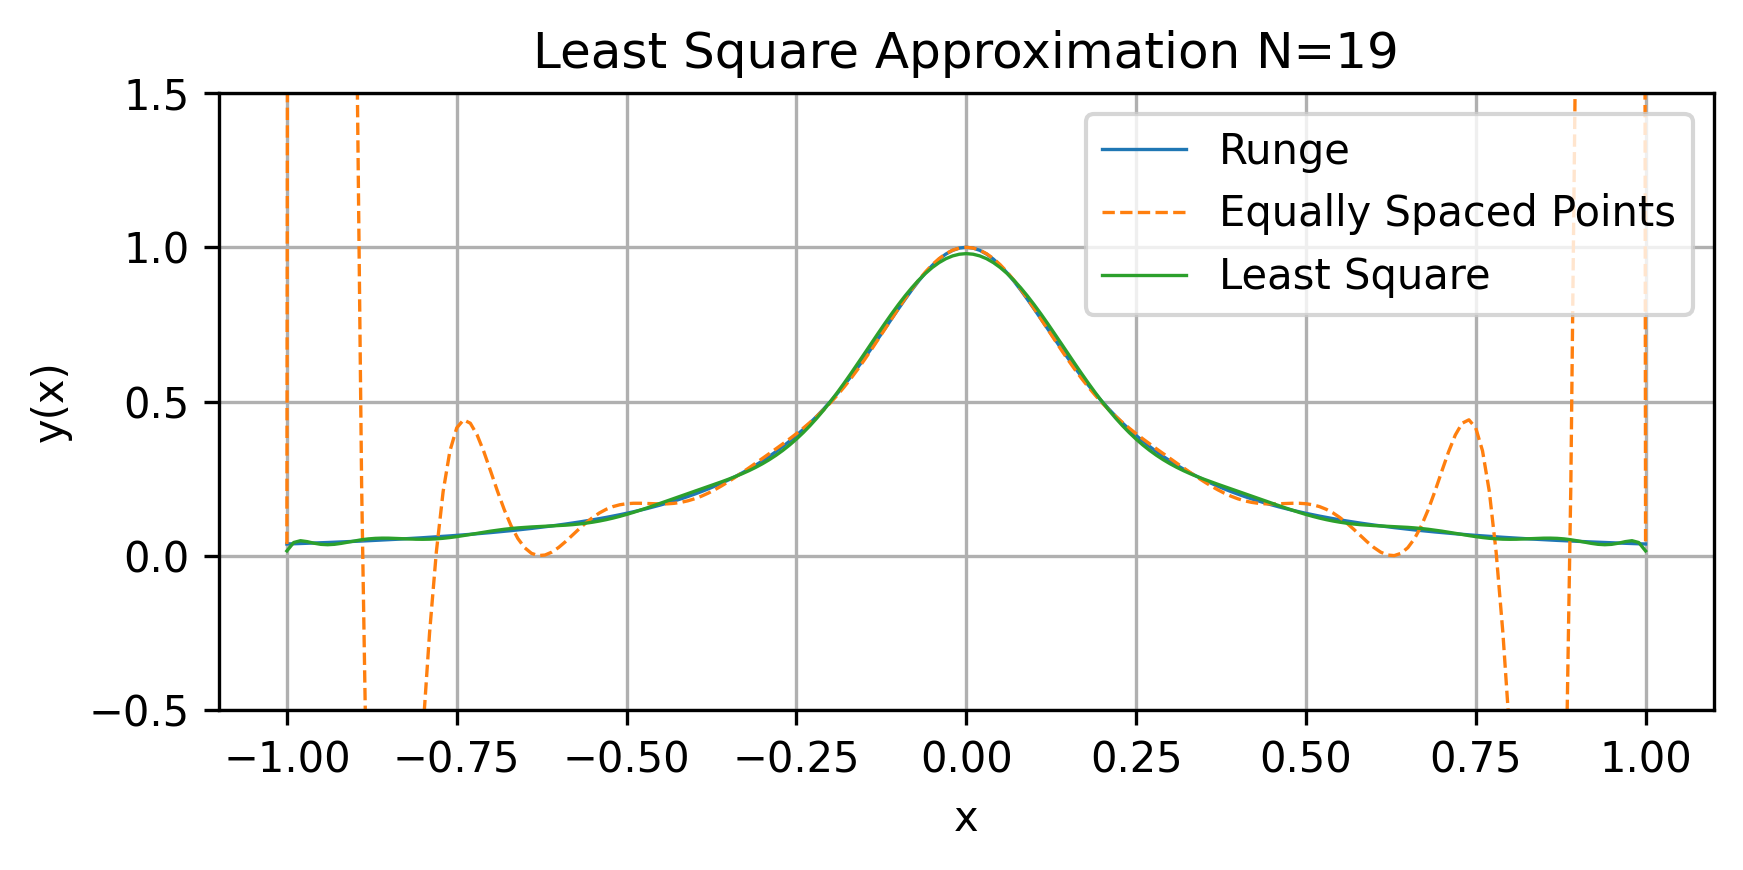

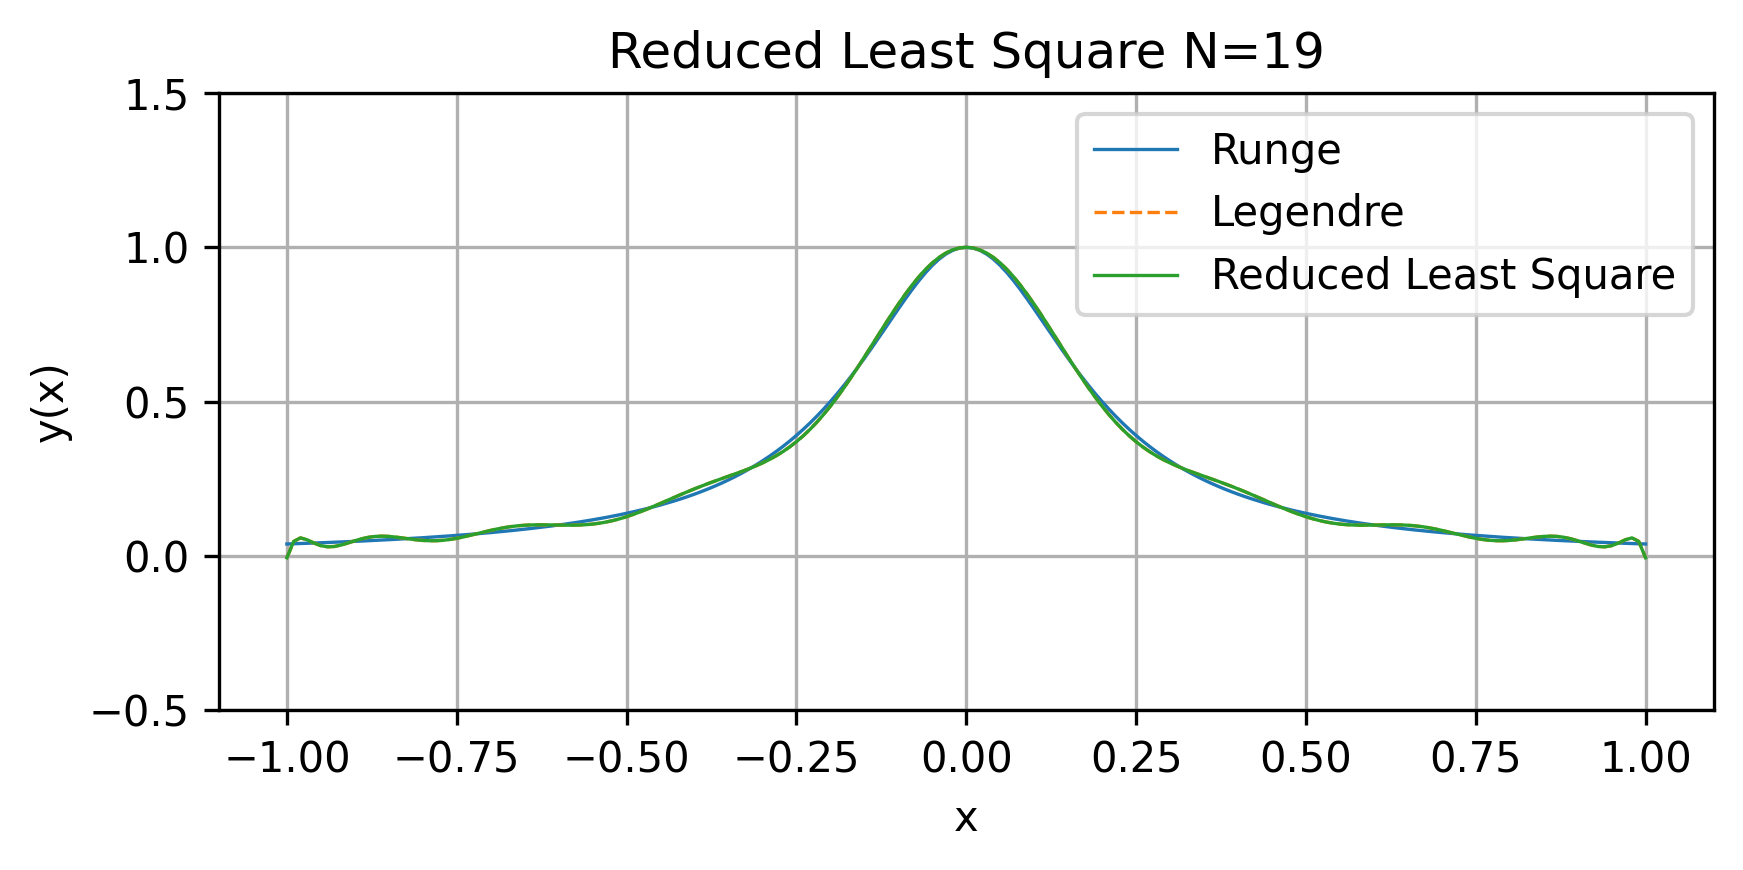

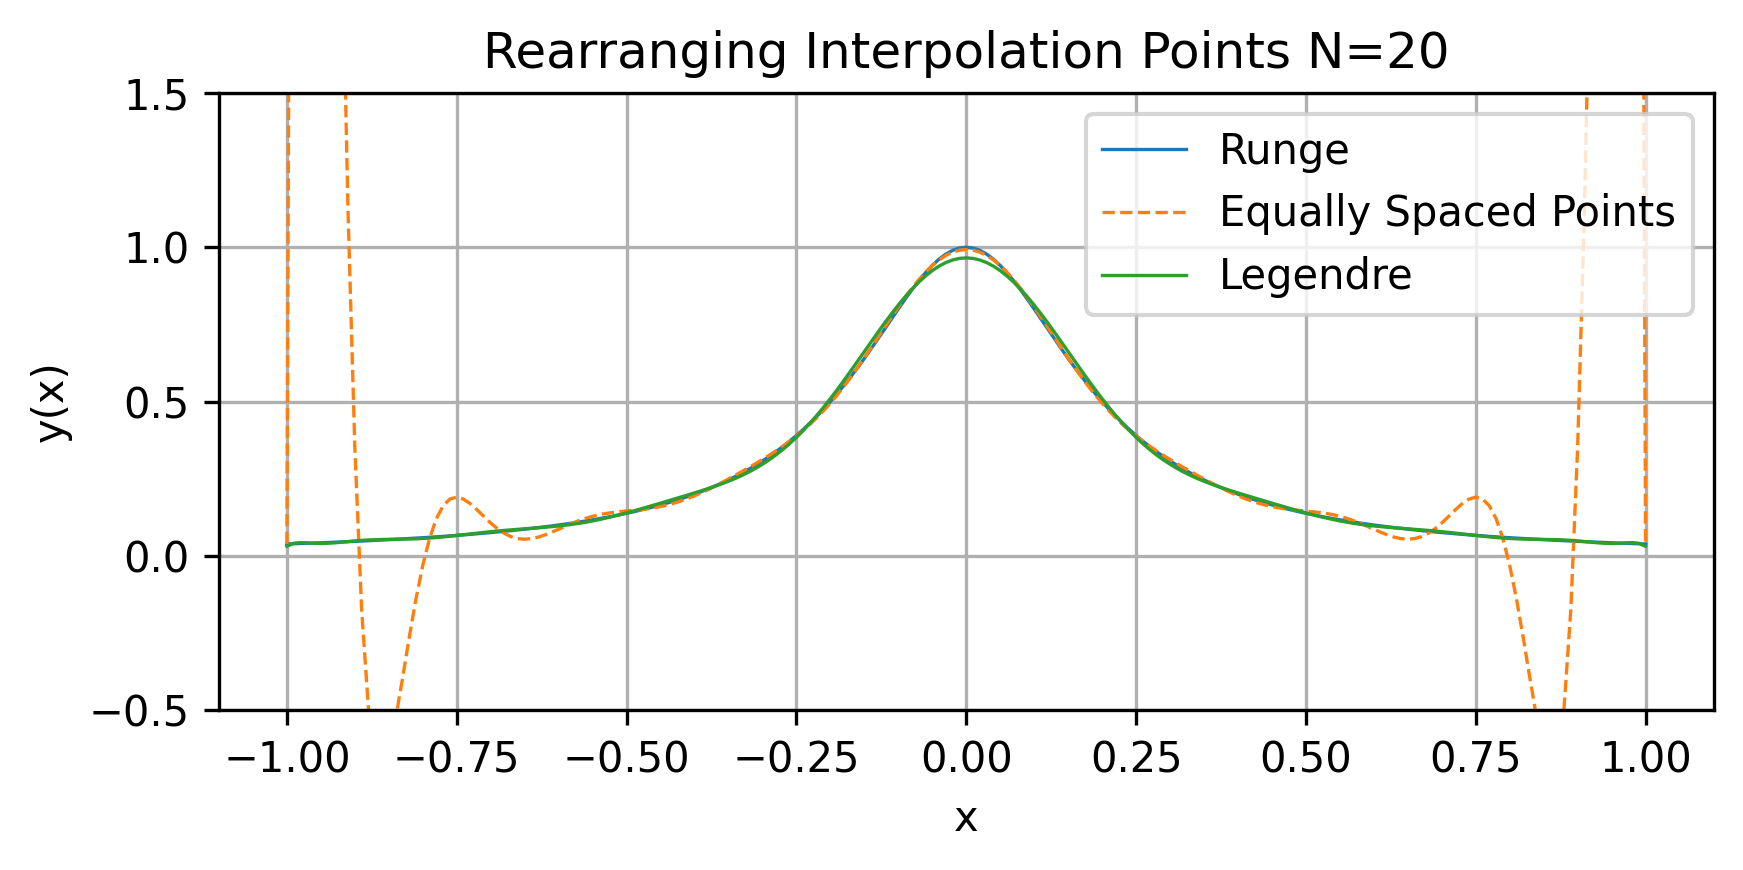

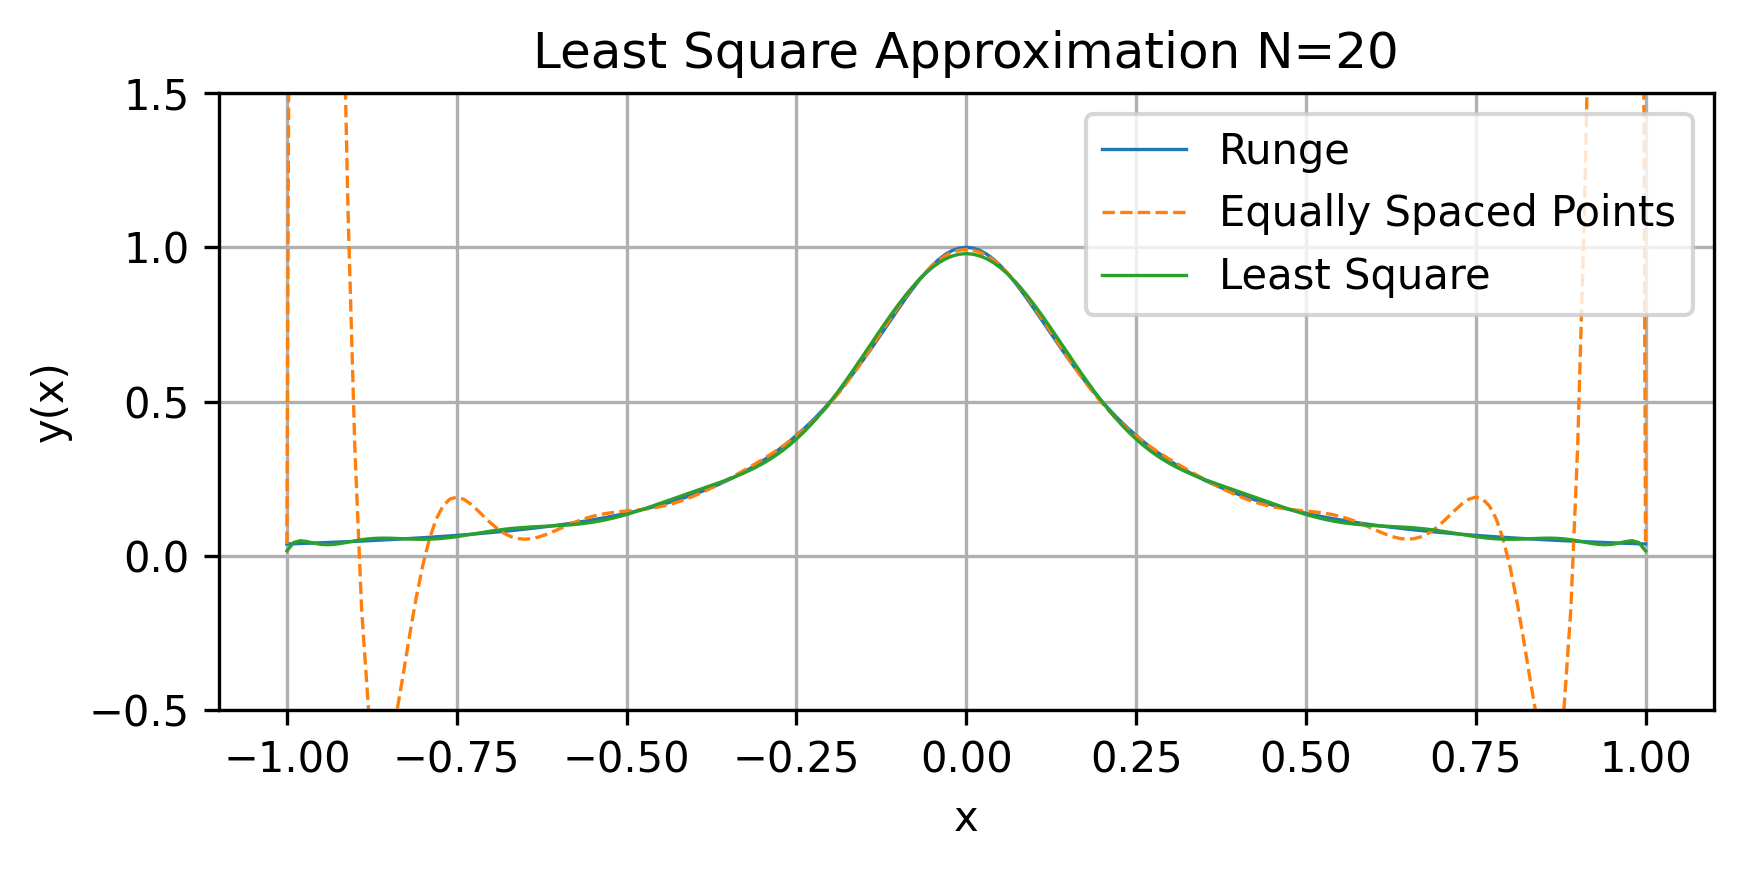

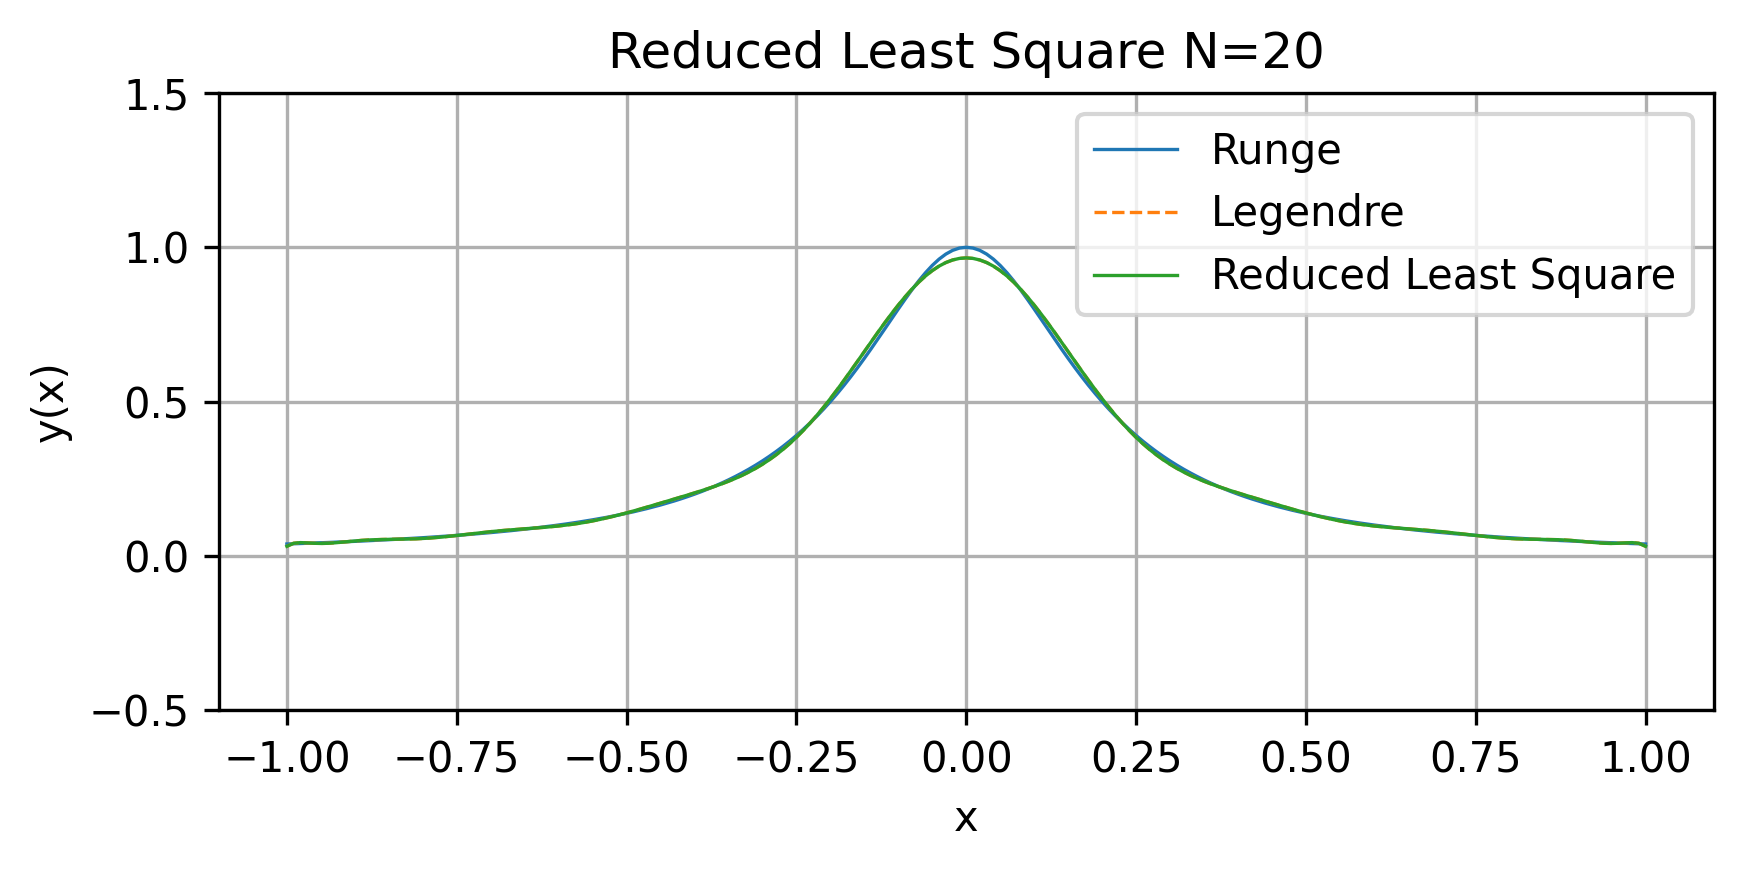

In [27]:
plot_nump=201#绘图点
a=-1#左端点
b=1#右端点
for N in range(15,21):
    h=(b-a)/(plot_nump-1)#绘图步长
    x=np.zeros(plot_nump)#初始化x
    new_poly=np.zeros(plot_nump)
    runge=np.zeros(plot_nump)
    Lege=np.zeros(plot_nump)
    Least=np.zeros(plot_nump)
    y_approx=np.zeros(plot_nump)
    
    [F_coe,z]=interpo_eq(N,a,b)#计算插值多项式系数
    
    w=legendre_roots(N)#计算Legendre多项式根
    L=interpo_any(w)#计算Legendre多项式根的插值多项式系数
    
    approximation = legendre_least_squares(funx, N)#使用N-1次Legendre多项式最小二乘逼近
    
    coefficients = least_squares_coefficients(N, f)
    
    for i in range(plot_nump):
        x[i]=a+i*h
        new_poly[i]=inter_poly(F_coe,z,x[i])#计算插值多项式在该点的值
        Lege[i]=inter_poly(L,w,x[i])
        runge[i]=f(x[i])#计算原函数在该点的值
        Least[i]= approximation.subs(sp.symbols('x'), x[i])
        y_approx[i] = approximate_function(x[i], coefficients)
    plt.figure(figsize=(6, 3), dpi=300)
    plt.ylim([-0.5,1.5])
    plt.plot(x,runge,label=f"Runge",linewidth=0.8)
    plt.plot(x,new_poly,label=f"Equally Spaced Points",linewidth=0.8,linestyle='--')
    plt.plot(x,Lege,label=f"Legendre",linewidth=0.8)
    plt.title('Rearranging Interpolation Points N={}'.format(N))
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6, 3), dpi=300)
    plt.ylim([-0.5,1.5])
    plt.plot(x,runge,label=f"Runge",linewidth=0.8)
    plt.plot(x,new_poly,label=f"Equally Spaced Points",linewidth=0.8,linestyle='--')
    plt.plot(x,Least,label=f"Least Square",linewidth=0.8)
    plt.title('Least Square Approximation N={}'.format(N))
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6, 3), dpi=300)
    plt.ylim([-0.5,1.5])
    plt.plot(x,runge,label=f"Runge",linewidth=0.8)
    plt.plot(x,Lege,label=f"Legendre",linewidth=0.8,linestyle='--')
    plt.plot(x,y_approx,label=f"Reduced Least Square",linewidth=0.8)
    plt.title('Reduced Least Square N={}'.format(N))
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()